In [53]:
import csv
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import pandas_datareader.data as web
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from matplotlib import pyplot
import scipy.stats
%matplotlib inline

In [3]:
fpath = 'facebook_data_investorsbusinessdaily_post_sentiment.tsv'
post_data = pd.read_csv(fpath, sep='\t')
post_data.head()

,ID,PostID,PostDate,Text,Likes,Shares,PositiveScore,NegativeScore,NeutralScore,SentimentScore,TokenQnt,PositiveScoreAvg,NegativeScoreAvg,NeutralScoreAvg,SentimentScoreAvg,Vader_Positive,Vader_Negative,Vader_Neutral,Vader_Compound,Flair_Score
0,0,1.015779e+16,2021-05-31 17:24:31.968425,Trade like the pro's and don't miss this speci...,3,0,0.000,0.000,8.000,0.000,8,0.000000,0.000,1.000000,0.000000,0.302,0.000,0.698,0.7477,0.9102
1,1,1.015779e+16,2021-05-31 17:24:33.154690,IBD’s #MemorialDay sale is here! Now’s your ch...,9,0,0.625,0.000,10.375,0.625,11,0.056818,0.000,0.943182,0.056818,0.217,0.000,0.783,0.7494,0.9942
2,2,1.015779e+16,2021-05-30 23:24:36.751058,IBD’s #MemorialDay sale is here! Now’s your ch...,11,1,0.625,0.000,10.375,0.625,11,0.056818,0.000,0.943182,0.056818,0.217,0.000,0.783,0.7494,0.9942
3,3,1.015779e+16,2021-05-30 16:57:00,IBD’s #MemorialDay sale is here! Now’s your ch...,14,0,0.625,0.000,10.375,0.625,11,0.056818,0.000,0.943182,0.056818,0.217,0.000,0.783,0.7494,0.9942
4,4,1.015778e+16,2021-05-30 15:16:00,"Work smarter, not harder. Working Smart Lets...",67,3,0.000,1.125,3.875,-1.125,5,0.000000,0.225,0.775000,-0.225000,0.174,0.131,0.695,0.1882,0.9932


In [4]:
post_data['Vader_Average'] = post_data['Vader_Positive'] - post_data['Vader_Negative']

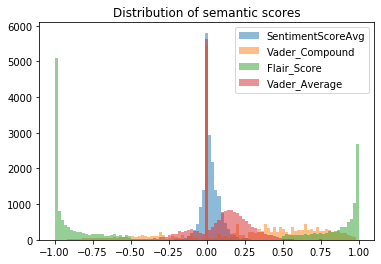

In [5]:
bins = np.linspace(-1, 1, 100)
pyplot.hist(post_data['SentimentScoreAvg'], bins, alpha=0.5, label='SentimentScoreAvg')
pyplot.hist(post_data['Vader_Compound'], bins, alpha=0.5, label='Vader_Compound')
pyplot.hist(post_data['Flair_Score'], bins, alpha=0.5, label='Flair_Score')
pyplot.hist(post_data['Vader_Average'], bins, alpha=0.5, label='Vader_Average')
pyplot.legend(loc='upper right')
pyplot.title('Distribution of semantic scores')
pyplot.show()

Text(0, 0.5, 'Posts')

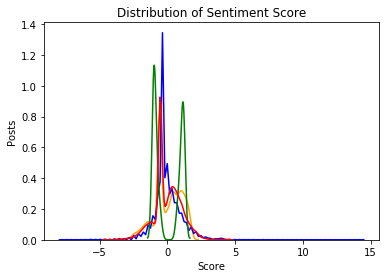

In [6]:


# seaborn histogram
sns.distplot((post_data['Vader_Compound'] - post_data['Vader_Compound'].mean())/post_data['Vader_Compound'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'orange',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['SentimentScoreAvg'] - post_data['SentimentScoreAvg'].mean())/post_data['SentimentScoreAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['Flair_Score'] - post_data['Flair_Score'].mean())/post_data['Flair_Score'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'green',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['Vader_Average'] - post_data['Vader_Average'].mean())/post_data['Vader_Average'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'red',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Distribution of Sentiment Score')
plt.xlabel('Score')
plt.ylabel('Posts')

In [7]:
post_data[['SentimentScoreAvg','Vader_Compound','Flair_Score','Vader_Average']].describe()

,SentimentScoreAvg,Vader_Compound,Flair_Score,Vader_Average
count,19131.000000,19131.000000,19131.000000,19131.000000
mean,0.023240,0.233178,-0.092344,0.084255
std,0.059895,0.412082,0.895683,0.161599
min,-0.437500,-0.965700,-1.000000,-0.624000
25%,0.000000,0.000000,-0.984200,0.000000
50%,0.012500,0.202300,-0.627500,0.065000
75%,0.050000,0.585900,0.920300,0.194000
max,0.875000,0.989100,1.000000,0.800000


In [8]:
post_data['PostDate'] = pd.to_datetime(post_data['PostDate'], errors='coerce')

post_data['DateMonth'] = post_data['PostDate'].dt.strftime('%Y-%m')
post_data['DateDay'] = post_data['PostDate'].dt.strftime('%Y-%m-%d')

In [11]:
post_data['DateDay'].head()

0    2021-05-31
1    2021-05-31
2    2021-05-30
3    2021-05-30
4    2021-05-30
Name: DateDay, dtype: object

In [12]:
post_data['DateMonth'].head()

0    2021-05
1    2021-05
2    2021-05
3    2021-05
4    2021-05
Name: DateMonth, dtype: object

In [13]:
Monthly_Data = post_data.groupby('DateMonth').agg({'SentimentScore': 'sum'
                                                         ,'TokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'Flair_Score':'mean'})

In [14]:
DailyData = post_data.groupby('DateDay').agg({'SentimentScore': 'sum'
                                                         ,'TokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'Flair_Score':'mean'})

In [15]:
DailyData['SentimentScoreAdj'] = DailyData['SentimentScore']/DailyData['TokenQnt']
Monthly_Data['SentimentScoreAdj'] = Monthly_Data['SentimentScore']/Monthly_Data['TokenQnt']


In [16]:
DailyData.head()

,SentimentScore,TokenQnt,Vader_Compound,Vader_Average,Flair_Score,SentimentScoreAdj
DateDay,,,,,,
2009-03-14,0.000,2,0.361450,0.179000,0.122250,0.0000
2009-03-17,0.375,3,0.132467,0.048333,-0.438233,0.1250
2009-03-18,1.500,2,0.334800,0.189500,-0.113000,0.7500
2009-03-19,0.500,2,0.255300,0.095500,-0.849750,0.2500
2009-03-20,-0.625,2,-0.285350,-0.132500,-0.220850,-0.3125


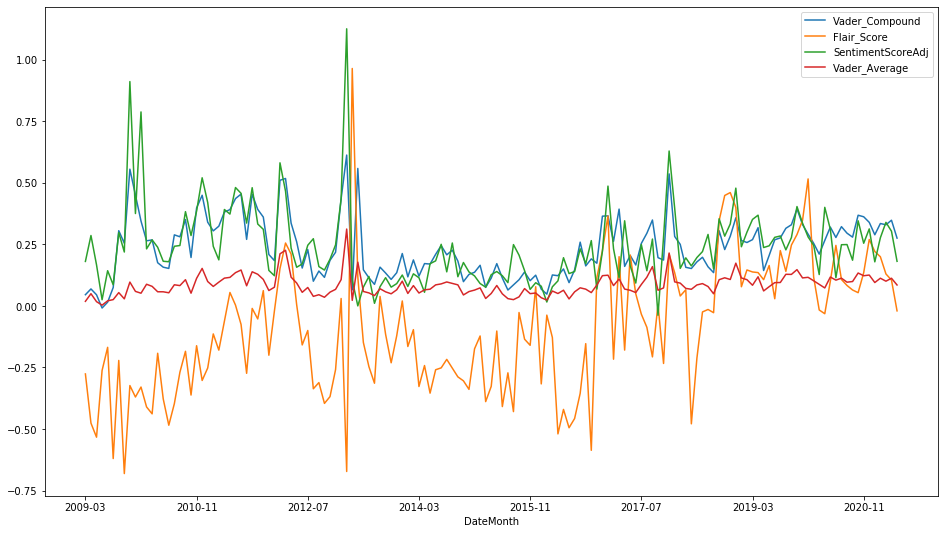

In [17]:
Monthly_Data[['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average']].plot(legend=True, figsize=(16,9))

## Download S&P from Yahoo

In [63]:
SnP_daily = web.get_data_yahoo('^GSPC','10/01/2014','05/01/2021',interval='d')
SnP_monthly = web.get_data_yahoo('^GSPC','10/01/2014','05/01/2021',interval='m')

In [64]:
SnP_monthly

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-10-01,2018.189941,1820.660034,1971.439941,2018.050049,93714040000,2018.050049
2014-11-01,2075.760010,2001.010010,2018.209961,2067.560059,63600190000,2067.560059
2014-12-01,2093.550049,1972.560059,2065.780029,2058.899902,80743820000,2058.899902
2015-01-01,2072.360107,1988.119995,2058.899902,1994.989990,77330040000,1994.989990
2015-02-01,2119.590088,1980.900024,1996.670044,2104.500000,68775560000,2104.500000
...,...,...,...,...,...,...
2021-01-01,3870.899902,3662.709961,3764.610107,3714.239990,105548790000,3714.239990
2021-02-01,3950.429932,3725.620117,3731.169922,3811.149902,98596960000,3811.149902
2021-03-01,3994.409912,3723.340088,3842.510010,3972.889893,120863560000,3972.889893


In [65]:
SnP_daily['LogReturn'] = np.log(SnP_daily['Adj Close']/SnP_daily['Adj Close'].shift(1))

In [66]:
SnP_monthly.index = SnP_monthly.index.strftime('%Y-%m')

In [67]:
SnP_monthly['LogReturn'] = np.log(SnP_monthly['Adj Close']/SnP_monthly['Adj Close'].shift(1))

## Granger test

In [68]:
Granger_data_daily = pd.merge(SnP_daily,DailyData, how= 'inner', left_index=True, right_index=True)

In [69]:
Granger_data_monthly = pd.merge(SnP_monthly,Monthly_Data, how= 'inner', left_index=True, right_index=True)

In [70]:
#Granger_data['SS_LogReturn'] = np.log((Granger_data['SentimentScoreAdj']+1)/(Granger_data['SentimentScoreAdj']+1).shift(1))

In [71]:
Granger_data_monthly

,High,Low,Open,Close,Volume,Adj Close,LogReturn,SentimentScore,TokenQnt,Vader_Compound,Vader_Average,Flair_Score,SentimentScoreAdj
2014-10,2018.189941,1820.660034,1971.439941,2018.050049,93714040000,2018.050049,NaN,6.750000,57,0.182046,0.085404,-0.288160,0.118421
2014-11,2075.760010,2001.010010,2018.209961,2067.560059,63600190000,2067.560059,0.024237,7.750000,44,0.098418,0.044409,-0.304241,0.176136
2014-12,2093.550049,1972.560059,2065.780029,2058.899902,80743820000,2058.899902,-0.004197,6.750000,49,0.127933,0.058184,-0.338882,0.137755
2015-01,2072.360107,1988.119995,2058.899902,1994.989990,77330040000,1994.989990,-0.031533,18.500000,152,0.136443,0.064197,-0.174167,0.121711
2015-02,2119.590088,1980.900024,1996.670044,2104.500000,68775560000,2104.500000,0.053439,22.875000,252,0.164856,0.073147,-0.122117,0.090774
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01,3870.899902,3662.709961,3764.610107,3714.239990,105548790000,3714.239990,-0.011199,33.625000,188,0.288806,0.094846,0.220708,0.178856
2021-02,3950.429932,3725.620117,3731.169922,3811.149902,98596960000,3811.149902,0.025757,54.769696,198,0.334448,0.112379,0.199584,0.276615
2021-03,3994.409912,3723.340088,3842.510010,3972.889893,120863560000,3972.889893,0.041563,81.750000,241,0.329398,0.100290,0.129792,0.339212
2021-04,4218.779785,3992.780029,3992.780029,4181.169922,82869290000,4181.169922,0.051097,61.250000,202,0.347788,0.112213,0.104840,0.303218


In [73]:
gc_res = grangercausalitytests(Granger_data_daily[["LogReturn","Vader_Compound"]].dropna(),11)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7862  , p=0.3754  , df_denom=1518, df_num=1
ssr based chi2 test:   chi2=0.7878  , p=0.3748  , df=1
likelihood ratio test: chi2=0.7875  , p=0.3748  , df=1
parameter F test:         F=0.7862  , p=0.3754  , df_denom=1518, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4972  , p=0.6083  , df_denom=1515, df_num=2
ssr based chi2 test:   chi2=0.9977  , p=0.6072  , df=2
likelihood ratio test: chi2=0.9974  , p=0.6073  , df=2
parameter F test:         F=0.4972  , p=0.6083  , df_denom=1515, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3071  , p=0.8203  , df_denom=1512, df_num=3
ssr based chi2 test:   chi2=0.9255  , p=0.8193  , df=3
likelihood ratio test: chi2=0.9252  , p=0.8193  , df=3
parameter F test:         F=0.3071  , p=0.8203  , df_denom=1512, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5968  , p=0.

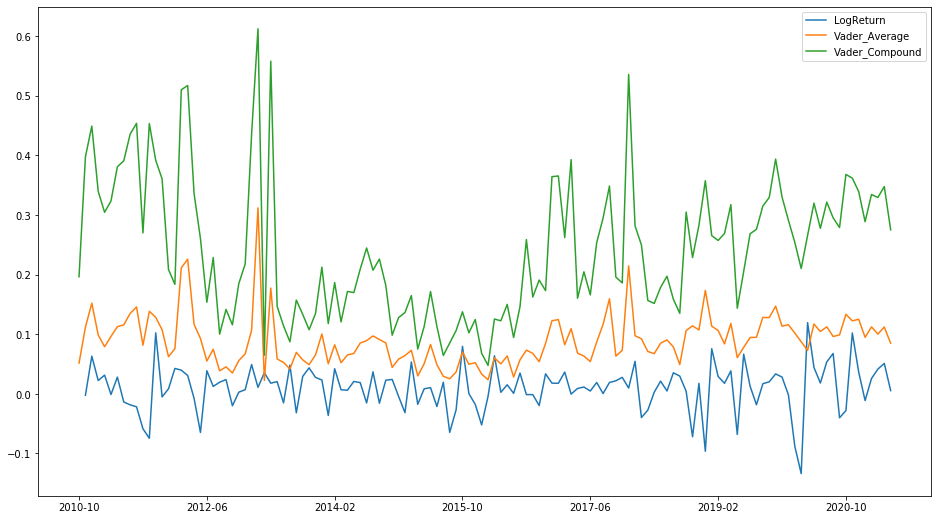

In [47]:
Granger_data_monthly[['LogReturn','Vader_Average','Vader_Compound']].plot(legend=True, figsize=(16,9))

In [51]:
corr = Granger_data_daily[['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average', 'LogReturn']].corr()
corr.style.background_gradient(cmap='coolwarm')

,Vader_Compound,Flair_Score,SentimentScoreAdj,Vader_Average,LogReturn
Vader_Compound,1.000000,0.398575,0.476523,0.923797,0.065604
Flair_Score,0.398575,1.000000,0.191748,0.406757,0.010021
SentimentScoreAdj,0.476523,0.191748,1.000000,0.387286,0.051959
Vader_Average,0.923797,0.406757,0.387286,1.000000,0.054010
LogReturn,0.065604,0.010021,0.051959,0.054010,1.000000


In [62]:
pvals = [] 
for col in ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average']:
    pvals.append(scipy.stats.linregress(Granger_data_daily['LogReturn'][1:], Granger_data_daily[col][1:].dropna())[3])
corr_signif = pd.DataFrame(pvals,columns = ['p-value']
                           ,index = ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average'])
corr_signif

,p-value
Vader_Compound,0.001402
Flair_Score,0.625973
SentimentScoreAdj,0.011445
Vader_Average,0.008569
